In [18]:
from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

# .npy 파일 불러오기
file_path = 'MDD/02010002.npy'
data = np.load(file_path)

# 데이터 프레임으로 변환
df = pd.DataFrame(data)

# 데이터 프레임 출력
print(df)

            0             1             2             3             4      \
0    -3624.792236  -3704.306641  -4190.941895  -4405.745605  -4078.846924   
1    -9476.124023  -9431.539062  -9680.532227  -9867.939453  -9749.339844   
2   -12770.934570 -12853.012695 -13366.354492 -13593.670898 -13250.940430   
3    -2160.621582  -2108.219971  -2405.166260  -2631.986328  -2484.651367   
4    -5090.987305  -5203.786133  -5765.671875  -5987.906250  -5603.920898   
..            ...           ...           ...           ...           ...   
124  -6028.678711  -6044.428711  -6167.542480  -6222.406738  -6136.926758   
125   3214.184570   3097.443359   2741.011719   2649.268066   2926.056396   
126  -7359.056152  -7436.727539  -7820.129395  -7993.155762  -7724.103027   
127  -9285.241211  -9363.327148  -9708.070312  -9856.702148  -9610.000977   
128      0.000000      0.000000      0.000000      0.000000      0.000000   

            5             6             7             8             9      

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense

# 데이터 로드 및 패딩 처리 함수
def load_and_pad_data_from_folder(folder_path, label, max_length):
    data = []
    labels = []
    file_count = 0
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            eeg_data = np.load(file_path)
            if eeg_data.shape[1] < max_length:
                pad_width = ((0, 0), (0, max_length - eeg_data.shape[1]))
                eeg_data = np.pad(eeg_data, pad_width, mode='constant')
            data.append(eeg_data)
            labels.append(label)
            file_count += 1
    print(f"Loaded {file_count} files from {folder_path}")
    return data, labels

# 최대 길이 설정 (Control과 MDD 데이터의 최대 길이)
mdd_lengths = [np.load(os.path.join('MDD', f)).shape[1] for f in os.listdir('MDD') if f.endswith('.npy')]
control_lengths = [np.load(os.path.join('Control', f)).shape[1] for f in os.listdir('Control') if f.endswith('.npy')]
max_length = max(max(mdd_lengths), max(control_lengths))

print(f"Maximum length: {max_length}")
print(f"MDD lengths: {mdd_lengths}")
print(f"Control lengths: {control_lengths}")

# MDD와 Control 데이터 로드 및 패딩 처리
mdd_data, mdd_labels = load_and_pad_data_from_folder('MDD', 1, max_length)
control_data, control_labels = load_and_pad_data_from_folder('Control', 0, max_length)

# 데이터 결합
data = mdd_data + control_data
labels = mdd_labels + control_labels

# 결합된 데이터의 길이 확인
print(f"Number of samples in data: {len(data)}")
print(f"Number of samples in labels: {len(labels)}")

# 데이터 결합 및 배열로 변환
X = np.array(data)
y = np.array(labels)


Maximum length: 83876
MDD lengths: [75189, 82651, 75126, 75339, 78639, 75176, 75652, 75201, 75226, 75126, 75276, 75401, 75351, 75126, 75101, 75389, 75289, 75176, 75402, 75127, 75089, 75114, 75114, 75151]
Control lengths: [75101, 75138, 75139, 75251, 76039, 75376, 75201, 75101, 75189, 75126, 75163, 75139, 75114, 83876, 75151, 83164, 75513, 75151, 75688, 75750, 75158, 75113, 75126, 75139, 75127, 75188, 75275, 75164]
Loaded 24 files from MDD
Loaded 28 files from Control
Number of samples in data: 52
Number of samples in labels: 52


In [4]:
'''
#패딩 사용하는 경우
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 데이터 로드 및 패딩 처리 함수
def load_and_pad_data_from_folder(folder_path, label, max_length):
    data = []
    labels = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            eeg_data = np.load(file_path)
            if eeg_data.shape[1] < max_length:
                eeg_data = np.pad(eeg_data, ((0, 0), (0, max_length - eeg_data.shape[1])), 'constant')
            data.append(eeg_data)
            labels.append(label)
    return data, labels

# 최대 길이 설정 (Control과 MDD 데이터의 최대 길이)
max_length = max(
    max([np.load(os.path.join('MDD', f)).shape[1] for f in os.listdir('MDD') if f.endswith('.npy')]),
    max([np.load(os.path.join('Control', f)).shape[1] for f in os.listdir('Control') if f.endswith('.npy')])
)

# MDD와 Control 데이터 로드 및 패딩 처리
mdd_data, mdd_labels = load_and_pad_data_from_folder('MDD', 1, max_length)
control_data, control_labels = load_and_pad_data_from_folder('Control', 0, max_length)

# 데이터 결합
X = np.array(mdd_data + control_data)
y = np.array(mdd_labels + control_labels)
'''

"\n#패딩 사용하는 경우\nimport os\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import accuracy_score\n\n# 데이터 로드 및 패딩 처리 함수\ndef load_and_pad_data_from_folder(folder_path, label, max_length):\n    data = []\n    labels = []\n    for file_name in os.listdir(folder_path):\n        if file_name.endswith('.npy'):\n            file_path = os.path.join(folder_path, file_name)\n            eeg_data = np.load(file_path)\n            if eeg_data.shape[1] < max_length:\n                eeg_data = np.pad(eeg_data, ((0, 0), (0, max_length - eeg_data.shape[1])), 'constant')\n            data.append(eeg_data)\n            labels.append(label)\n    return data, labels\n\n# 최대 길이 설정 (Control과 MDD 데이터의 최대 길이)\nmax_length = max(\n    max([np.load(os.path.join('MDD', f)).shape[1] for f in os.listdir('MDD') if f.endswith('.npy')]),\n    max([np.load(os.path.join

In [5]:
mdd_data

[array([[ -3624.79223633,  -3704.30664062,  -4190.94189453, ...,
              0.        ,      0.        ,      0.        ],
        [ -9476.12402344,  -9431.5390625 ,  -9680.53222656, ...,
              0.        ,      0.        ,      0.        ],
        [-12770.93457031, -12853.01269531, -13366.35449219, ...,
              0.        ,      0.        ,      0.        ],
        ...,
        [ -7359.05615234,  -7436.72753906,  -7820.12939453, ...,
              0.        ,      0.        ,      0.        ],
        [ -9285.24121094,  -9363.32714844,  -9708.0703125 , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ]]),
 array([[-14399.66992188, -14506.06347656, -14606.74023438, ...,
              0.        ,      0.        ,      0.        ],
        [-12279.59375   , -12346.109375  , -12431.53027344, ...,
              0.        ,      0.     

In [6]:
control_data

[array([[ -5962.91357422,  -5922.03662109,  -5989.37548828, ...,
              0.        ,      0.        ,      0.        ],
        [-10141.62597656, -10099.31835938, -10160.08398438, ...,
              0.        ,      0.        ,      0.        ],
        [ -6683.28222656,  -6626.66113281,  -6763.39648438, ...,
              0.        ,      0.        ,      0.        ],
        ...,
        [-10822.71386719, -10736.63476562, -10873.68945312, ...,
              0.        ,      0.        ,      0.        ],
        [-12353.96386719, -12260.22167969, -12404.82128906, ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ]]),
 array([[-1866.51037598, -1794.07958984, -1967.83959961, ...,
             0.        ,     0.        ,     0.        ],
        [-7278.04589844, -7255.97705078, -7376.37304688, ...,
             0.        ,     0.        ,     0.

In [7]:
mdd_data[0].shape

(129, 83876)

In [8]:
control_data[0].shape

(129, 83876)

In [9]:
mdd_labels

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [20]:
X

array([[[ -3624.79223633,  -3704.30664062,  -4190.94189453, ...,
              0.        ,      0.        ,      0.        ],
        [ -9476.12402344,  -9431.5390625 ,  -9680.53222656, ...,
              0.        ,      0.        ,      0.        ],
        [-12770.93457031, -12853.01269531, -13366.35449219, ...,
              0.        ,      0.        ,      0.        ],
        ...,
        [ -7359.05615234,  -7436.72753906,  -7820.12939453, ...,
              0.        ,      0.        ,      0.        ],
        [ -9285.24121094,  -9363.32714844,  -9708.0703125 , ...,
              0.        ,      0.        ,      0.        ],
        [     0.        ,      0.        ,      0.        , ...,
              0.        ,      0.        ,      0.        ]],

       [[-14399.66992188, -14506.06347656, -14606.74023438, ...,
              0.        ,      0.        ,      0.        ],
        [-12279.59375   , -12346.109375  , -12431.53027344, ...,
              0.        ,      0.     

In [10]:
X.shape

(52, 129, 83876)

In [11]:
y.shape

(52,)

In [12]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Conv1D 모델 구성
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2024-07-17 02:46:21.608060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0
2024-07-17 02:46:21.610353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:88:00.0, compute capability: 8.0


In [14]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


2024-07-17 02:46:27.626002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-07-17 02:46:28.739871: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f777ffaf0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-17 02:46:28.739922: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-07-17 02:46:28.739930: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-07-17 02:46:28.744958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-17 02:46:28.825683: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 7s 2s/step - loss: 670504.5625 - accuracy: 0.6585 - val_loss: 692322.7500 - val_accuracy: 0.5455
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 820772.1875 - accuracy: 0.6098 - val_loss: 303806.7500 - val_accuracy: 0.4545
Epoch 3/10
2/2 [==============================] - 1s 796ms/step - loss: 158550.2500 - accuracy: 0.7073 - val_loss: 242038.8594 - val_accuracy: 0.3636
Epoch 4/10
2/2 [==============================] - 1s 736ms/step - loss: 51986.2930 - accuracy: 0.8293 - val_loss: 216433.3125 - val_accuracy: 0.5455
Epoch 5/10
2/2 [==============================] - 1s 416ms/step - loss: 72186.8359 - accuracy: 0.8293 - val_loss: 248051.7344 - val_accuracy: 0.5455
Epoch 6/10
2/2 [==============================] - 1s 425ms/step - loss: 11013.4053 - accuracy: 0.9024 - val_loss: 375427.3125 - val_accuracy: 0.5455
Epoch 7/10
2/2 [==============================] - 1s 369ms/step - loss: 34744.4688 - accuracy: 0.9024 - val_loss: 342776

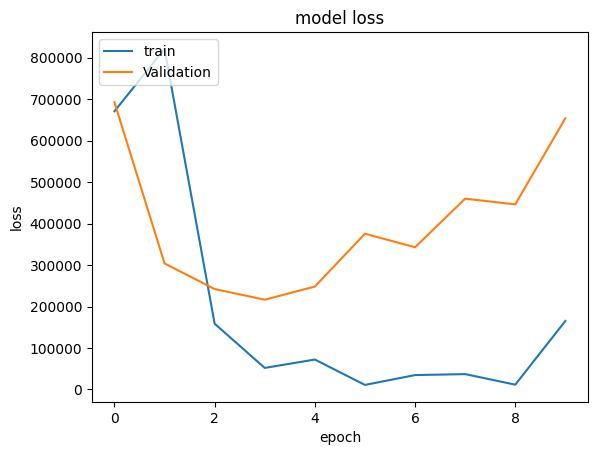

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

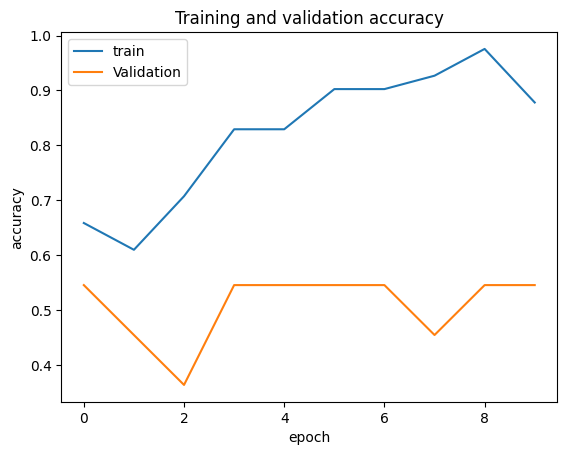

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

import seaborn as sns

predy=model.predict(X_test)
predy=np.argmax(predy, axis=-1)
LABELS = ['Control', 'MDD']
cm=confusion_matrix(y_test,predy)
print(cm)
print(accuracy_score(y_test,predy))
print(f1_score(y_test,predy, average='weighted'))
print(classification_report(y_test,predy))

1/1 [==============================] - 0s 296ms/step
[[5 0]
 [6 0]]
0.45454545454545453
0.2840909090909091
              precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       0.00      0.00      0.00         6

    accuracy                           0.45        11
   macro avg       0.23      0.50      0.31        11
weighted avg       0.21      0.45      0.28        11



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
